In [91]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.optim import lr_scheduler

In [92]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [93]:
from pathlib import Path
root_dir = 'Images'
# Print the paths to check if the dataset is being read correctly
count = 0
for folder in Path(root_dir).iterdir():
    if folder.is_dir():
        print(f'Folder: {folder}')
        num_breed = 0
        for img_file in folder.iterdir():
            num_breed += 1
            count += 1
        print(num_breed)
print(count)



Folder: Images\n02085620-Chihuahua
152
Folder: Images\n02085782-Japanese_spaniel
185
Folder: Images\n02085936-Maltese_dog
252
Folder: Images\n02086079-Pekinese
149
Folder: Images\n02086240-Shih-Tzu
214
Folder: Images\n02086646-Blenheim_spaniel
188
Folder: Images\n02086910-papillon
196
Folder: Images\n02087046-toy_terrier
172
Folder: Images\n02087394-Rhodesian_ridgeback
172
Folder: Images\n02088094-Afghan_hound
239
Folder: Images\n02088238-basset
175
Folder: Images\n02088364-beagle
195
Folder: Images\n02088466-bloodhound
187
Folder: Images\n02088632-bluetick
171
Folder: Images\n02089078-black-and-tan_coonhound
159
Folder: Images\n02089867-Walker_hound
153
Folder: Images\n02089973-English_foxhound
157
Folder: Images\n02090379-redbone
148
Folder: Images\n02090622-borzoi
151
Folder: Images\n02090721-Irish_wolfhound
218
Folder: Images\n02091032-Italian_greyhound
182
Folder: Images\n02091134-whippet
187
Folder: Images\n02091244-Ibizan_hound
188
Folder: Images\n02091467-Norwegian_elkhound
196

# Create dataset

In [94]:
data_dir = 'Images'

# Define data transforms
data_transforms = transforms.Compose([
    transforms.Resize((150, 150)),  
    transforms.ToTensor()])



dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)


print(f"Number of images: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Class names: {dataset.classes}")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Number of images: 20580
Number of classes: 120
Class names: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_t

# Display images from dataset and its label

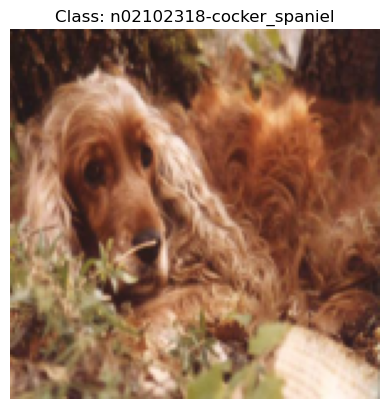

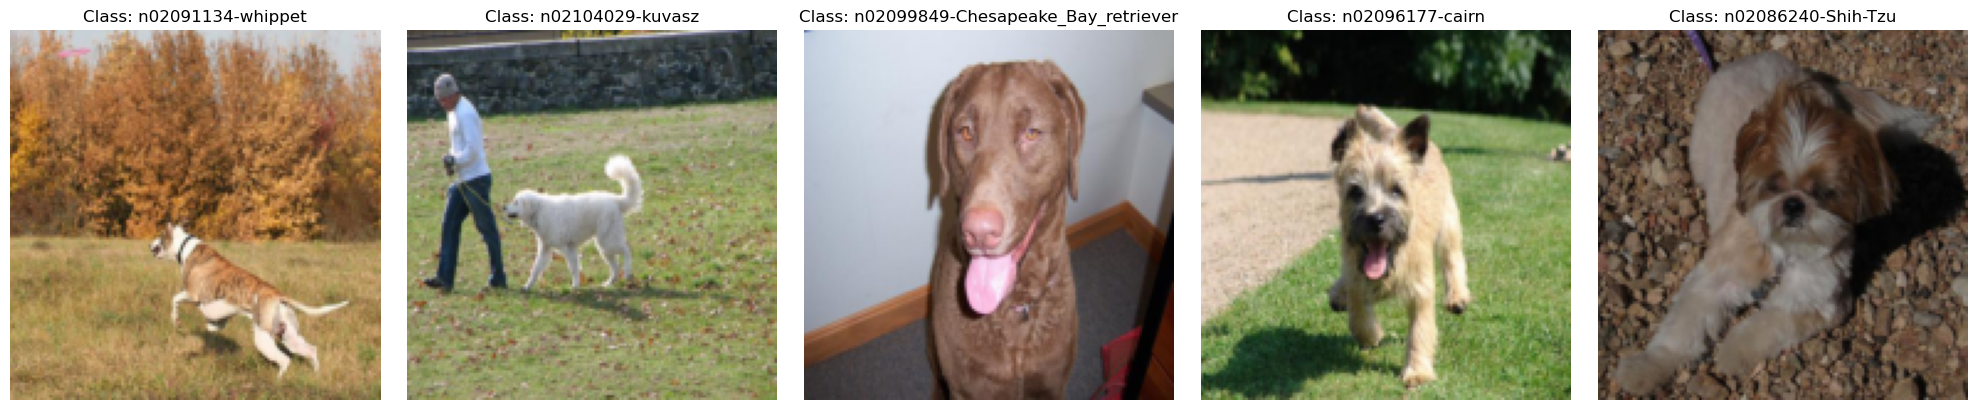

In [95]:
import matplotlib.pyplot as plt
import random
import numpy as np
def display_image_and_label(dataset, index):
    #choose the img and its label
    img, label = dataset[index]
    
    #convert to numpy for displaying
    img = img.permute(1, 2, 0).numpy()
    
    #dog breed
    class_name = dataset.classes[label]
    
    #show the image
    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.axis('off')
    plt.show()

#choose a random image
random_index = random.randint(0, len(dataset) - 1)
display_image_and_label(dataset, random_index)

#show many images
num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))
for i in range(num_images_to_display):
    random_index = random.randint(0, len(dataset) - 1)
    img, label = dataset[random_index]
    img = img.permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(f"Class: {dataset.classes[label]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Create the model

In [96]:
class CNNClassification(nn.Module):
    def __init__(self):
        super(CNNClassification, self).__init__()
        self.CNN_Model = nn.Sequential(
            #3x150x150
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            #32x75x75

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            #64x37x37

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            #128x18x18

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            #256x9x9

            nn.Flatten(),
            #256 * 9 * 9 
            nn.Linear(256 * 9 * 9, 2048),
            nn.Linear(2048,1024),
            nn.Linear(1024, 512),
            nn.Linear(512, 120)  # 120 output breeds
        )

    def forward(self, x):
        return self.CNN_Model(x)


In [97]:
Cnn_model = CNNClassification()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Cnn_model.parameters(), lr=0.01,momentum=0.9, weight_decay=0.000001)
Cnn_model.to(device)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training

In [98]:
import copy


def train_the_model(num_epochs=5):
    accuracies = []
    max_accuracy = 0
    best_model = None
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = Cnn_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy after each batch
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability (predicted class)
            total += labels.size(0)  # Total number of labels in the batch
            correct += (predicted == labels).sum().item()  # Compare predicted and actual labels
            
            # Accumulate loss for display
            running_loss += loss.item()

        # Calculate accuracy for the entire epoch
        accuracy = (correct / total) * 100
        accuracies.append(accuracy)
        
        # Learning rate scheduler step
        scheduler.step()

        # Save the best model
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(Cnn_model)
            max_accuracy = accuracy
            print("Saving best model with Accuracy:", accuracy)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_dataloader):.4f}, Accuracy: {accuracy:.2f}%")

    # Plot accuracy over epochs
    plt.plot(accuracies)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy Over Epochs")
    plt.show()

    return best_model


Saving best model with Accuracy: 1.1175898931000972
Epoch 1/20, Loss: 4.7839, Accuracy: 1.12%
Saving best model with Accuracy: 2.326287657920311
Epoch 2/20, Loss: 4.6373, Accuracy: 2.33%
Saving best model with Accuracy: 3.96622934888241
Epoch 3/20, Loss: 4.4276, Accuracy: 3.97%
Saving best model with Accuracy: 5.885568513119534
Epoch 4/20, Loss: 4.2287, Accuracy: 5.89%
Saving best model with Accuracy: 7.756316812439261
Epoch 5/20, Loss: 4.0858, Accuracy: 7.76%
Saving best model with Accuracy: 14.364674441205052
Epoch 6/20, Loss: 3.6987, Accuracy: 14.36%
Saving best model with Accuracy: 16.818513119533527
Epoch 7/20, Loss: 3.5561, Accuracy: 16.82%
Saving best model with Accuracy: 18.731778425655975
Epoch 8/20, Loss: 3.4264, Accuracy: 18.73%
Saving best model with Accuracy: 21.805150631681244
Epoch 9/20, Loss: 3.2708, Accuracy: 21.81%
Saving best model with Accuracy: 25.498056365403304
Epoch 10/20, Loss: 3.0708, Accuracy: 25.50%
Saving best model with Accuracy: 35.56243926141885
Epoch 11

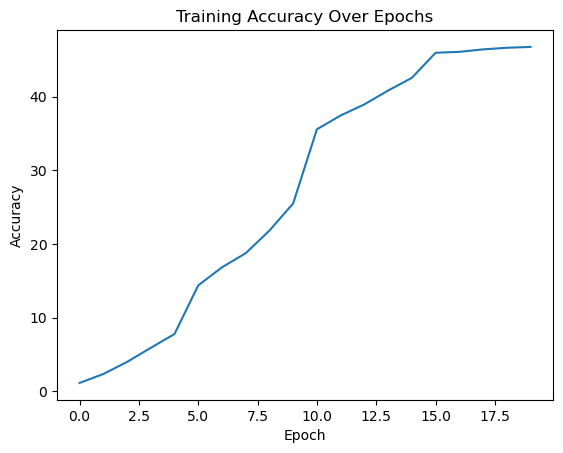

In [99]:
result_model = train_the_model(20)